# Semi-supervised anomaly detection: log mel-spectrogram - model 2

This notebook will show to implement in Tensorflow the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
)

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [4]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [5]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

We will use 64 log mel-band energies from a spectrogram with an analysis frame of 64 ms and 50% hop size. 

In [6]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64, num_spectrogram_bins=512+1, sample_rate=16_000, dtype=tf.float32
)

In [7]:
def mel(item):
    audio = tf.cast(item["audio"], tf.float32)
    audio = audio / 2**15

    # Calculate the STFT of the audio signal
    stfts = tf.signal.stft(
            audio,
            frame_length=1024,
            frame_step=512,
            pad_end=False,  # librosa test compatibility
        )
    # Get Magnitude fo the STFT
    mag_stfts = tf.abs(stfts)

    # Get the mel-spectrogram
    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    # Change of base for logarithmics: from natural logarithmic to common logarithmic 
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    # Calculate the log-mel spectrogram    
    log_melgrams = 20 / 2 * _tf_log10(melgrams + 10e-6)

    # Concat 5 time frames together to feed the model
    concat_melgrams = tf.concat(
        [
            tf.roll(log_melgrams, shift=1, axis=0),
            tf.roll(log_melgrams, shift=2, axis=0),
            log_melgrams,
            tf.roll(log_melgrams, shift=-1, axis=0),
            tf.roll(log_melgrams, shift=-2, axis=0)
        ],
        axis=1,
    )
    concat_melgrams = concat_melgrams[2:-2,:]

    item["audio"] = concat_melgrams
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [8]:
def prep_train(item):
    return item["audio"], item["audio"]

In [9]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(mel)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(mel)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(mel)
test2 = test.batch(BATCH_SIZE)

## Training

This is the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

In [10]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=(307, 320)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(320, activation=None)
    ]
)

In [11]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 307, 64)           20544     
_________________________________________________________________
dense_1 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 307, 8)            520       
_________________________________________________________________
dense_3 (Dense)              (None, 307, 64)           576       
_________________________________________________________________
dense_4 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_5 (Dense)              (None, 307, 320)          20800     
Total params: 50,760
Trainable params: 50,760
Non-trainable params: 0
____________________________________________________

We use same parameters as the paper.

In [12]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [13]:
log_dir = os.path.join('..', 'logs', 'semi-mel2', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [14]:
checkpoint_filepath = os.path.join("tmp", "semi-mel2", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [15]:
history = autoencoder.fit(
    train2,
    epochs=50,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/50
6/6 [==============================] - 37s 7s/step - loss: 131.5260 - val_loss: 124.3305
Epoch 2/50
6/6 [==============================] - 35s 6s/step - loss: 118.6004 - val_loss: 91.6566
Epoch 3/50
6/6 [==============================] - 35s 6s/step - loss: 84.3889 - val_loss: 60.1496
Epoch 4/50
6/6 [==============================] - 35s 6s/step - loss: 53.3748 - val_loss: 36.2654
Epoch 5/50
6/6 [==============================] - 35s 6s/step - loss: 32.8922 - val_loss: 25.0411
Epoch 6/50
6/6 [==============================] - 34s 6s/step - loss: 23.5036 - val_loss: 20.3421
Epoch 7/50
6/6 [==============================] - 34s 6s/step - loss: 19.6969 - val_loss: 18.4068
Epoch 8/50
6/6 [==============================] - 34s 6s/step - loss: 18.2528 - val_loss: 17.5049
Epoch 9/50
6/6 [==============================] - 34s 6s/step - loss: 17.2564 - val_loss: 17.0637
Epoch 10/50
6/6 [==============================] - 34s 6s/step - loss: 16.8216 - val_loss: 16.8417
Epoch 11/50
6/6 

## Testing

In [44]:
autoencoder.load_weights(checkpoint_filepath)

In [45]:
VERSION="1"
saved_model_path = autoencoder.save(
    os.path.join("..", "..", "..", "production", "backend", "models", "mel2", VERSION),
    save_format="tf",
)

INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\mel2\1\assets


INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\mel2\1\assets


Let's join train and test set together for faster predictions.

In [46]:
audios = train.concatenate(test)

In [47]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

Let's compute the reconstruction error for all audios.

In [48]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [49]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df["split"] = audios_df["split"].cat.rename_categories({0: "train", 1: "test"})
audios_df["label"] = audios_df["label"].cat.rename_categories({0: "normal", 1: "anomaly"})

audios_df.sample(5)

In [50]:
audios_df["error"] = error_lst

,audio,id,machine_id,split,label
3529,"[[-1.1623789, 1.3479097, -2.1374764, -3.346869...",0029,04,test,normal
540,"[[0.70172435, -2.8372908, -3.9320188, -3.99027...",0209,04,train,normal
3546,"[[-6.183357, -2.5788953, -0.7882048, -2.315836...",0044,04,test,anomaly
1516,"[[-4.244346, -3.504946, -1.8163147, -6.0503874...",0326,02,train,normal
3480,"[[-2.301365, 0.40528092, 0.32432023, -3.027490...",0069,02,test,anomaly


In [51]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
2741,"[[3.3571997, 0.516589, -3.018223, 2.5505614, -...",0670,00,train,normal,26.291147
2595,"[[1.4216573, -8.550894, -3.7455986, -3.610457,...",0618,00,train,normal,30.211065
1507,"[[-11.695938, -9.718228, -4.644026, -4.6665306...",0049,04,train,normal,9.294355
2128,"[[-2.1655934, -3.5943105, -7.217829, -5.506896...",0119,02,train,normal,30.726698
2052,"[[-10.242925, -9.562217, -13.214911, -7.074456...",0689,00,train,normal,24.325224


Let's compute the mean and the standard deviation of the reconstruction error of the train set.

In [52]:
(
    audios_df
    .query("split == 'train'")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error           
                 mean        std
machine_id                      
00          27.623725  16.880158
02          28.280608  16.451567
04          27.400117  15.035054
06          27.932139  15.279758

Let's compute the mean and the standard deviation of the reconstruction error of the test set.

In [53]:
(
    audios_df
    .query("split == 'test'")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error           
                         mean        std
label   machine_id                      
normal  00          31.841238  22.761163
        02          28.729560  16.376651
        04          29.844615  17.800294
        06          31.837210  18.220654
anomaly 00          36.568466  21.687862
        02          33.552183  24.828593
        04          30.780051  18.901578
        06          30.030023  16.999487

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

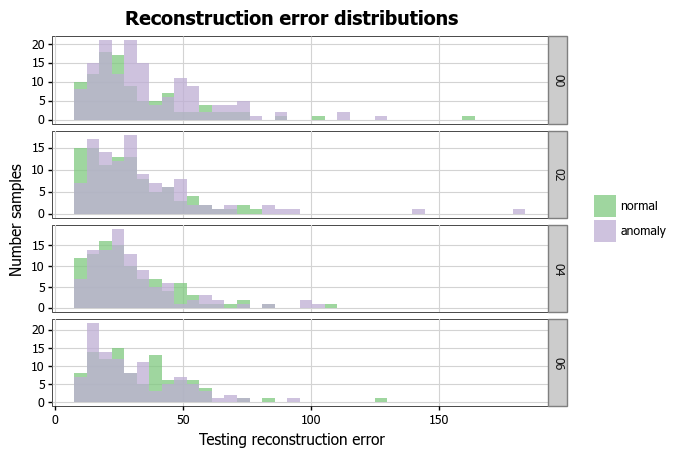

In [54]:
p = (
    p9.ggplot(audios_df.query("split == 'test'"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Testing reconstruction error")
    + p9.scale_y_continuous(name="Number samples")
    + p9.labs(
        title="Reconstruction error distributions",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [55]:
avg = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .std()
)

threshold = avg + std

In [56]:
print(threshold)

43.852141731951406


Let's create a new column with the predicted label based on the threshold.

In [57]:
audios_df["label_pred"] = audios_df["error"] > threshold

In [58]:
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[[-2.7215207, 2.083169, 0.12187265, 1.1148239,...",0811,02,train,normal,25.931948,False
1,"[[2.2777703, 0.44747186, -5.78151, -13.740477,...",0144,00,train,normal,11.265621,False
2,"[[-8.147932, 3.0302932, 3.3327494, -2.8137136,...",0773,06,train,normal,15.062402,False
3,"[[1.5884889, 2.7002306, -0.03556317, -3.426373...",0425,02,train,normal,33.704685,False
4,"[[1.4445103, -4.519986, -8.349353, -5.5056186,...",0191,04,train,normal,24.302830,False


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

In [59]:
audios_df["label"] = audios_df["label"].cat.rename_categories({"normal": 0, "anomaly": 1})

### Machine_id=00

In [60]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.44      0.78      0.57       100
           1       0.67      0.31      0.43       143

    accuracy                           0.51       243
   macro avg       0.56      0.55      0.50       243
weighted avg       0.58      0.51      0.48       243



In [61]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[78 22]
 [98 45]]


In [62]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5473


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=02

In [63]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61       100
           1       0.59      0.24      0.34       111

    accuracy                           0.51       211
   macro avg       0.54      0.53      0.48       211
weighted avg       0.54      0.51      0.47       211



In [64]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[81 19]
 [84 27]]


In [65]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5266


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=04

In [66]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.82      0.61       100
           1       0.45      0.15      0.23       100

    accuracy                           0.48       200
   macro avg       0.47      0.48      0.42       200
weighted avg       0.47      0.48      0.42       200



In [67]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[82 18]
 [85 15]]


In [68]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4850


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=06

In [69]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.49      0.77      0.60       100
           1       0.49      0.22      0.30       102

    accuracy                           0.49       202
   macro avg       0.49      0.49      0.45       202
weighted avg       0.49      0.49      0.45       202



In [70]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[77 23]
 [80 22]]


In [71]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4928


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

Although we tried to copy the model of the paper, metrics are worse.